In [1]:
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances, nan_euclidean_distances
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.optimize import linear_sum_assignment
from fcmeans import FCM

import numpy as np
import matplotlib.pyplot as plt
import cmasher as cmr
import timeit
import random

import lib.utils as u
import lib.cluster_utils as cu
import lib.linear_utils as lu

In [2]:
# Remove logging info otherwise the output of the cell gets  huge
import logging
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

In [3]:
%reload_ext autoreload
%autoreload 2

In [4]:
%matplotlib widget

# Load data and define variables

In [5]:
signal = np.load(r'data/sim/sim_sig_5movs_5feats.npy')
ground_boundaries = np.load(r'data/sim/sim_gtbound_5movs_5feats.npy')
ground_labels = np.load(r'data/sim/sim_gtlabel_5movs_5feats.npy')

In [6]:
seed = 42
random.seed(seed)
np.random.seed(seed)

# Calculating 'activity' periods

In [7]:
# change threshold according to the amplitude of the 'movement' returned
thresh = 0.015
# change min length according to the time-scale of the quiet periods you observe
min_length = 30
quiet_periods, movement = u.find_quiet_periods(signal, sfreq=0.05, thresh=thresh, min_length=min_length, bord=0)

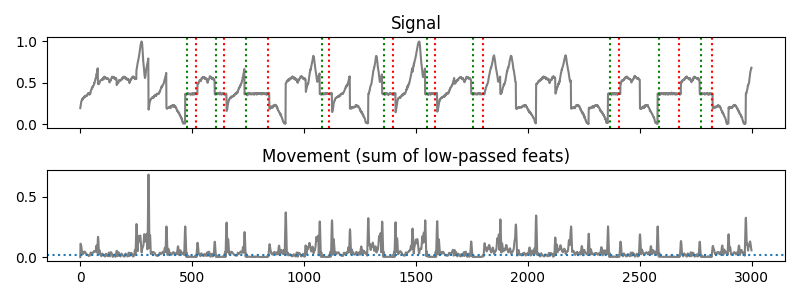

In [8]:
# Helper-plot
fig, ax = plt.subplots(figsize=(8,3), nrows=2, sharex=True)

# change to reflect parts of the signal you are interested in
t_min = max(0, 0)
t_max = min(len(signal), 3_000)

ax[0].plot(signal[t_min:t_max,-1], color='gray')
for qs, qe in quiet_periods:
    if qs < t_min: continue
    if qe > t_max: break
    ax[0].axvline(qs-t_min, linestyle='dotted', color='green')
    ax[0].axvline(qe-t_min, linestyle='dotted', color='red');
ax[0].set_title('Signal')

ax[1].plot(movement[t_min:t_max], color='gray')
ax[1].axhline(thresh, linestyle='dotted')
ax[1].set_title('Movement (sum of low-passed feats)')

plt.tight_layout();

In [9]:
# change win_size according to your data time-scale
win_size = 80
valid_starts = u.get_valid_starts(len(signal), quiet_periods, win_size, overlap=0)
valid_periods = u.runs_of_ones(valid_starts)

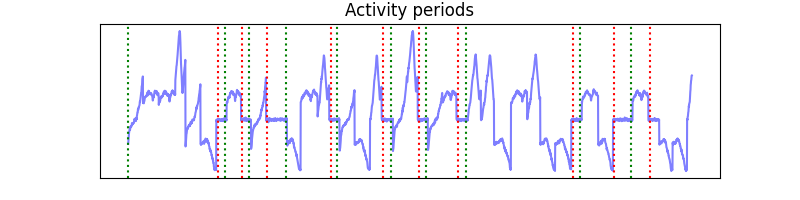

In [10]:
# change to reflect parts of the signal you are interested in
t_min = max(0, 0)
t_max = min(len(signal), 3_000)

fig = plt.figure(figsize=(8,2))
plt.title('Activity periods')
plt.plot(signal[t_min:t_max,-1], color='blue', alpha=0.5)
for qs, qe in valid_periods:
    if qs < t_min:
        continue
    if qe > t_max:
        break
    plt.axvline(qs-t_min, linestyle='dotted', color='green')
    plt.axvline(qe-t_min, linestyle='dotted', color='red');
plt.xticks([])
plt.yticks([]);

# Initial segmentation and clustering

In [11]:
# customize the step_size
# PCA note: the more overlaps, the less informative are the pc's
step_size = win_size//3

In [12]:
# collect initial segmentation boundaries
init_boundaries = []
i = 0
while i < len(signal)-win_size:
    w = valid_starts[i:i+win_size]
    if sum(w) > win_size * 0.95:
        init_boundaries.append([i,i+win_size])
        i += step_size
    else:
        i += 1
init_boundaries = np.array(init_boundaries)
print(init_boundaries.shape)

(1812, 2)


In [13]:
# accumulate the segments
init_segments = cu.get_segments(signal, init_boundaries, nan=False)
print(init_segments.shape)

(1812, 80, 5)


In [14]:
# change the nuumber to
# either desired ratio of variance explained
# or concerete number of componen
n_components = 0.8
# dimensionality reduction of the segments
pca = PCA(n_components=n_components)
pca.fit(np.r_[cu.flat_concat_segments(init_segments)])
print(f'{pca.n_components_} components explain at least 0.8 of variance')
init_segments_embed = pca.transform(cu.flat_concat_segments(init_segments))

7 components explain at least 0.8 of variance


In [15]:
# change the number accordingly to data
n_clusters = 5
# cluster the dim.reduced segments
m = cu.estimate_fuzzifier(init_segments_embed.shape[0], init_segments_embed.shape[1])
fcm = FCM(n_clusters=n_clusters,m=m,random_state=seed)
fcm.fit(init_segments_embed)
# outputs
init_centers = fcm.centers
init_labels = fcm.predict(init_segments_embed)
soft_labels = fcm.soft_predict(init_segments_embed)
labels = np.max(soft_labels, axis=1)

In [16]:
# filter the dense space
# using the f-means scores
t_start = timeit.default_timer()

# filter_idx, filter_order = cu.fix_singular_overlaps(labels, init_boundaries)
filter_idx = cu.divide_and_fix(labels, init_boundaries)

t_end = timeit.default_timer()
time_interval = (t_end-t_start)/60
print(f'{time_interval:1.3f}')

83977
8398083985
83988



  0%|          | 0/4 [00:00<?, ?it/s]

0.218


In [17]:
boundaries = init_boundaries[filter_idx]

# Visualize the initial state

In [18]:
cmap = cmr.get_sub_cmap('Set1', 0, 0.8, N=n_clusters+1)

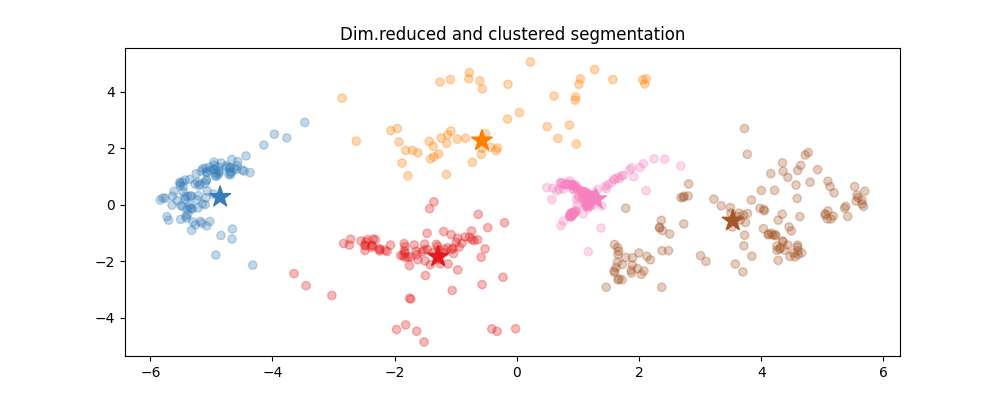

In [19]:
fig = plt.figure(figsize=(10,4))

# how many clusters to plot?
n = 5
n = min(n_clusters, np.unique(init_labels[filter_idx]).shape[0])
n_shuffle = np.random.choice(np.unique(init_labels), n, replace=False)
n_zip = np.array([[i,lab] for i,lab in enumerate(init_labels[filter_idx]) if lab in n_shuffle])
n_idx, n_labels = n_zip.T

plt.scatter(init_segments_embed[filter_idx][n_idx,0], init_segments_embed[filter_idx][n_idx,1], 
            c=n_labels, cmap=cmap, alpha=0.3)

n_centers = np.array([ele for i,ele in enumerate(init_centers) if i in n_shuffle])
plt.scatter(n_centers[:,0], n_centers[:,1], c=np.arange(n_clusters), marker='*', s=250, cmap=cmap)

plt.title('Dim.reduced and clustered segmentation')
plt.show()

Below: the rows span features and the columns - clusters

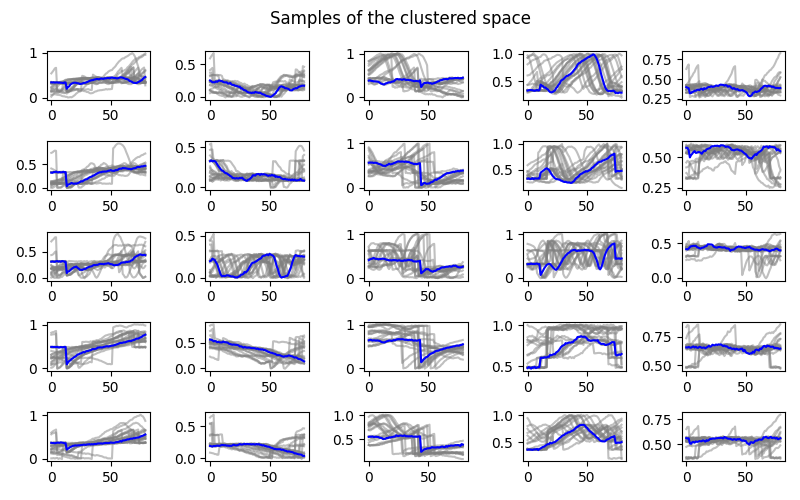

In [20]:
n_features = signal.shape[1]

fig,ax = plt.subplots(figsize=(8,5), ncols=n, nrows=n_features, squeeze=False)
plt.suptitle('Samples of the clustered space')

# note: assigning the filtered segments to 'init_segments'
init_segments = cu.get_segments(signal, boundaries, nan=True)
init_segments_centers = cu.get_centers(signal, boundaries, n_labels, mode='mean', real=True)

n_segments = 20

for c in range(n):
    c_ind = np.where(n_labels==c)[0]
    c_ind = np.random.choice(c_ind, min(len(c_ind), n_segments), replace=False)
    for n in range(n_features):
        ax[n,c].plot(init_segments[c_ind,:,n].T, color='gray', alpha=0.5)
        ax[n,c].plot(init_segments_centers[c][:, n], color='blue')

plt.tight_layout();

# TASC

Note:

1. Ground truth is present depending on the dataset. If none - you can exclude the fields from the dictionary.

In [21]:
eval_metrics = ['silhouette', 'dunn']
scores_dictionary = {'silhouette': 'up', 'dunn': 'up', 'avg_in': 'down', 'avg_out': 'up'}

In [22]:
tacom_history = {}
tacom_history[0] = {'boundaries':boundaries, 'labels':n_labels, 'embed':init_segments_embed[filter_idx], 
                    'ground_boundaries':ground_boundaries,'ground_labels':ground_labels, 
                    'align_idx': np.arange(boundaries.shape[0]), 'centers': init_centers,
                    'params': np.array([[0,1] for i in range(boundaries.shape[0])])}
init_eval = cu.eval_clusters(tacom_history[0]['embed'], tacom_history[0]['labels'], eval_metrics)
tacom_history[0]['evals'] = init_eval

In [23]:
n_epochs = 1

In [24]:
time_off = np.arange(-10, 11)
len_off = np.arange(-10, 11)
alpha = 0.5
filtparam = 4.5

In [25]:
def tacom_call():
    t_start = timeit.default_timer()
    for n in range(n_epochs):
        
        print(f'Aligning space, epoch {n+1}')
        align_boundaries, align_idx, gap_idx, align_params,*_ = cu.align_all_sequentially(
            signal, tacom_history[n]['boundaries'], tacom_history[n]['labels'], valid_starts=valid_starts,
            time_off=time_off, len_off=len_off, alpha=alpha, filtparam=filtparam) 
        
        print('Embedding the space')
        align_segments = cu.get_segments(signal, align_boundaries, nan=False)
        align_segments[align_idx] = [lu.warp_linear(s,p, crop=True)[0] for s,p in zip(align_segments[align_idx], align_params[align_idx])]
        # calculating the new average size of the segments
        new_size = int(np.mean([b[1]-b[0] for b in align_boundaries[align_idx]]))
        pca_align_segments = cu.flat_concat_segments(np.array([u.my_resample(e, 1, len(e), new_size) for e in align_segments]))
        # we redefine the pca as we set it to explain
        # n% of variance
        pca = PCA(n_components=n_components)
        align_segments_embed = pca.fit_transform(pca_align_segments)
        
        print('Cluster the space')
        model = KMeans(n_clusters=n_clusters, n_init=10)
        align_labels = model.fit_predict(align_segments_embed)

        if len(gap_idx) > 0:
            print('Aligning gaps')
            _, _, _, cluster_sizes = cu.get_sizes(align_boundaries[align_idx], align_labels[align_idx])
            centers = cu.get_centers(signal, align_boundaries, align_labels, cluster_sizes)
            for gi in gap_idx:
                gi_res = cu.score_temp_variants(signal, align_boundaries[gi], centers[align_labels[gi]],
                                                np.arange(1), np.arange(1), alpha=alpha, valid_starts=valid_starts)
                align_boundaries[gi] = gi_res[0][0]
                align_params[gi] = gi_res[-1][0]

            pca_align_segments[gap_idx] = cu.flat_concat_segments(np.array([u.my_resample(e, 1, len(e), new_size) for e in 
                                                np.array([lu.warp_linear(s,p, crop=True)[0] for s,p in 
                                                        zip(cu.get_segments(signal, align_boundaries[gap_idx], nan=False), 
                                                        align_params[gap_idx])], dtype=object)]))
            align_segments_embed = pca.fit_transform(pca_align_segments)
            align_labels = model.fit_predict(align_segments_embed)
            
        print('Evaluating and saving results')
        evals = cu.eval_clusters(align_segments_embed, align_labels, metrics=eval_metrics)
        for key,e in evals.items():
            print(f'{key}: {e:.3f} ({scores_dictionary[key]})')

        tacom_history[n+1] = {'boundaries':align_boundaries, 'labels':align_labels,
                    'gap_idx':gap_idx, 'align_idx':align_idx, 'params':align_params,
                       'evals': evals, 'embed': align_segments_embed, 'centers': model.cluster_centers_}

    t_end = timeit.default_timer()
    time_interval = (t_end-t_start)/60
    print(f'{time_interval:1.3f}')

In [26]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    tacom_call()

Aligning space, epoch 1
Filtering out clusters with filt_param=4.5


Filtering clusters:   0%|          | 0/5 [00:00<?, ?it/s]

Size of a subgroup of clusters: {0: 80, 1: 80, 2: 80, 3: 80, 4: 80}
Starting 8 processes. PIDs:
840068400984012


84019
84024
84031
84034

84039

  0%|          | 0/516 [00:00<?, ?it/s]

Finished multiprocessed alignment
Starting post-processing
88748
88751
88756


  0%|          | 0/393 [00:00<?, ?it/s]

88761


  0%|          | 0/110 [00:00<?, ?it/s]

89058


  0%|          | 0/1 [00:00<?, ?it/s]

Inserted 19 gaps
Embedding the space
Cluster the space
Aligning gaps
Evaluating and saving results
silhouette: 0.762 (up)
dunn: 0.093 (up)
223.680


# Clustering evaluation

## Evaluation metrics

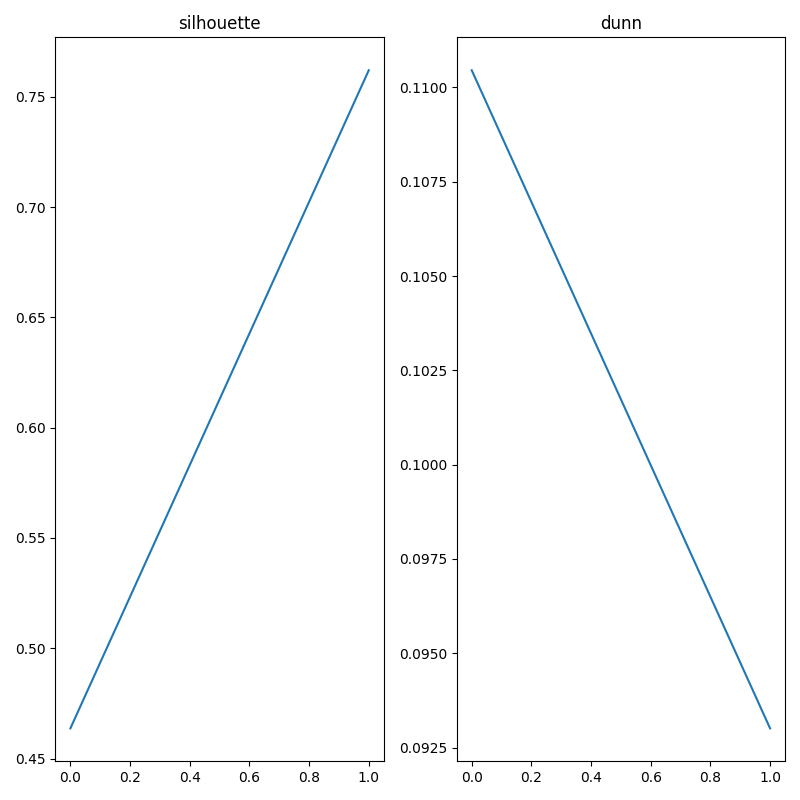

In [27]:
evals_keys = tacom_history[0]['evals'].keys()
nrows = len(evals_keys)//2
ncols = len(evals_keys)//nrows
fig,ax = plt.subplots(figsize=(8,8), nrows=nrows, ncols=ncols)
ax = ax.flat
for j,key in enumerate(evals_keys):
    evals = [tacom_history[i]['evals'][key] for i in tacom_history.keys()]
    ax[j].plot(evals)
    ax[j].set_title(f'{key}')
plt.tight_layout();

## Clusters' progress in time domain

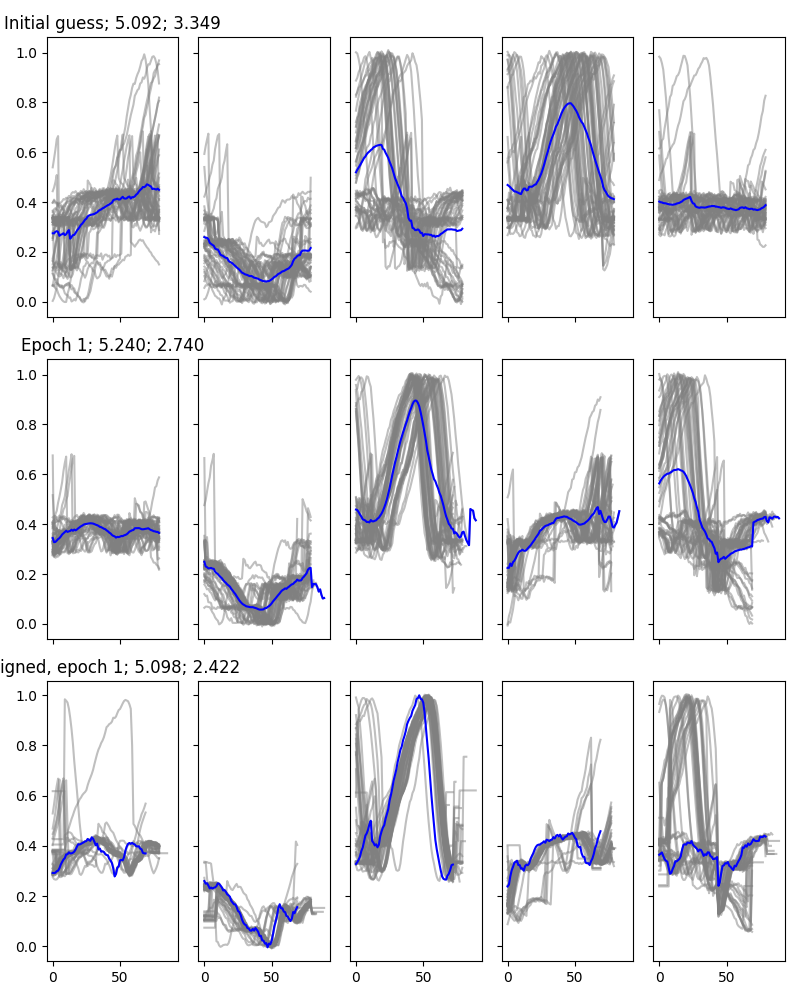

In [28]:
# customize according to your needs
feat = 0            # feature to plot
n_show = [1]        # epochs to show
n_segments = 50     # how many segments to plot in a single subplot

def calc_average_dist(centers, members, sizes):
    return np.mean(nan_euclidean_distances(cu.flat_concat_segments(cu.full_nans(members)[:,:int(sizes)]), 
                   cu.flat_concat_segments(np.array([u.my_resample(centers, 1, len(centers), int(sizes))]))))

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    
    fig,ax = plt.subplots(figsize=(8,10), nrows=1+2*(len(n_show)), ncols=n_clusters, sharex=True, sharey='row')

    dist_reg = []
    dist_bell = []
    _,_,_,cluster_sizes = cu.get_sizes(tacom_history[0]['boundaries'], tacom_history[0]['labels'])
    temp_segments = cu.get_segments(signal, tacom_history[0]['boundaries'], nan=True)
    temp_centers = cu.get_centers(signal, tacom_history[0]['boundaries'], 
                                  tacom_history[0]['labels'], cluster_sizes, mode='mean', real=True)
    for c in range(n_clusters):
        c_ind = np.where(tacom_history[0]['labels']==c)[0]
        c_ind = np.random.choice(c_ind, min(len(c_ind), n_segments), replace=False)
        c_segments = temp_segments[c_ind]
        for t in c_segments:
            ax[0][c].plot(t[:,feat].T, color='gray', alpha=0.5)
        ax[0][c].plot(np.nanmean(c_segments, axis=0)[:,feat], color='blue')
        dist_reg.append(calc_average_dist(temp_centers[c], temp_segments, cluster_sizes[c]))
        dist_bell.append(np.mean(u.weightedL2_all(c_segments, np.array(temp_centers[c]))))
    dist_reg = np.mean(dist_reg)
    dist_bell = np.mean(dist_bell)
    ax[0][0].set_title(f'Initial guess; {dist_reg:.3f}; {dist_bell:.3f}')

    for i,idx in enumerate(n_show):
        _,_,_,cluster_sizes = cu.get_sizes(tacom_history[idx]['boundaries'], tacom_history[idx]['labels'])
        temp_segments = cu.get_segments(signal, tacom_history[idx]['boundaries'], nan=True)
        temp_centers = cu.get_centers(signal, tacom_history[idx]['boundaries'],
                                      tacom_history[idx]['labels'], cluster_sizes, mode='mean', real=True)
        dist_reg = []
        dist_bell = []
        for c in range(n_clusters):
            c_ind = np.where(tacom_history[idx]['labels']==c)[0]
            c_ind = np.random.choice(c_ind, min(len(c_ind), n_segments), replace=False)
            c_segments = temp_segments[c_ind]
            for t in c_segments:
                ax[1+2*i][c].plot(t[:,feat], color='gray', alpha=0.5)
            ax[1+2*i][c].plot(np.nanmean(c_segments, axis=0)[:,feat], color='blue')
            dist_reg.append(calc_average_dist(temp_centers[c], temp_segments, cluster_sizes[c]))
            dist_bell.append(np.mean(u.weightedL2_all(c_segments, np.array(temp_centers[c]))))
        dist_reg = np.mean(dist_reg)
        dist_bell = np.mean(dist_bell)
        ax[1+2*i][0].set_title(f'Epoch {idx}; {dist_reg:.3f}; {dist_bell:.3f}')

        dist_reg = []
        dist_bell = []
        temp_segments = cu.get_segments(signal, tacom_history[idx]['boundaries'], nan=False)
        temp_segments = np.array([lu.warp_linear(t, tacom_history[idx]['params'][i], crop=False)[0] for i,t in enumerate(temp_segments)], dtype=object)
        temp_centers = cu.get_centers(signal, tacom_history[idx]['boundaries'],
                                      tacom_history[idx]['labels'], cluster_sizes, mode='mean', real=True)
        for c in range(n_clusters):
            c_ind = np.where(tacom_history[idx]['labels']==c)[0]
            c_ind = np.random.choice(c_ind, min(len(c_ind), n_segments), replace=False)
            c_segments = temp_segments[c_ind]
            for t in c_segments:
                ax[2+2*i][c].plot(t[:,feat], color='gray', alpha=0.5)
            ax[2+i*2][c].plot(temp_centers[c][:,feat], color='blue')
            dist_reg.append(calc_average_dist(temp_centers[c], temp_segments, cluster_sizes[c]))
            dist_bell.append(np.mean(u.weightedL2_all(c_segments, np.array(temp_centers[c]))))
        dist_reg = np.mean(dist_reg)
        dist_bell = np.mean(dist_bell)
        ax[2+i*2][0].set_title(f'Aligned, epoch {idx}; {dist_reg:.3f}; {dist_bell:.3f}')

    plt.tight_layout();

## Clusters' progress in the dim. reduced space

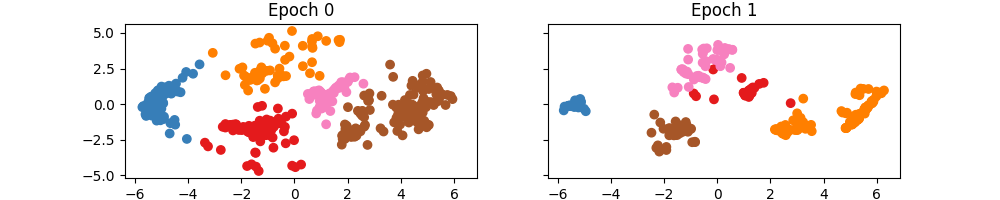

In [29]:
n_show = [0,1] # epochs to show

fig, ax = plt.subplots(figsize=(10,2), ncols=len(n_show), sharex=True, sharey=True)

for e,n in enumerate(n_show):
    temp_segments = cu.get_segments(signal, tacom_history[n]['boundaries'], nan=False)
    temp_segments = [lu.warp_linear(s,p, crop=False)[0] for s,p in zip(temp_segments, tacom_history[n]['params'])]
    # pca_align_segments = np.array([sig.resample(e, new_size).T.flatten() for e in align_segments])
    # calculate the new_size
    new_size, *_ = cu.get_sizes(tacom_history[n]['boundaries'], tacom_history[n]['labels'])
    temp_segments = cu.flat_concat_segments(np.array([u.my_resample(e, 1, len(e), new_size) for e in temp_segments]))

    pca = PCA(n_components=2)
    temp_segments = pca.fit_transform(temp_segments)

    ax[e].scatter(temp_segments[:,0], temp_segments[:,1], c=tacom_history[n]['labels'], cmap=cmap);
    ax[e].set_title(f'Epoch {n}');

# Segmentation evaluation

In [30]:
overlap_iou_scores = []
overlap_indices = []
overlap_labels = []
overlap_new_labels = {}

n_executed = n_epochs + 1

segments_scores = {'Overlap':np.zeros(n_executed), 'Boundaries distance':np.zeros(n_executed), 'Boundaries success': np.zeros(n_executed),} 
#                    'Adjusted rand':np.zeros(n_executed), 'Homogeneity':np.zeros(n_executed), 'Completeness':np.zeros(n_executed),
#                   'V Measure':np.zeros(n_executed), 'Fowlkes':np.zeros(n_executed)}

y_true = tacom_history[0]['ground_boundaries']
for e,idx in enumerate(np.arange(n_executed)):
    y_pred = tacom_history[idx]['boundaries']
    min_len = min(y_true.shape[0], y_pred.shape[0])
    max_len = max(y_true.shape[0], y_pred.shape[0])
    
    # Find the indices of the ground truth segments that are significantly overlapped by the predicted segments
    iou_scores = np.zeros((y_true.shape[0], y_pred.shape[0]))
    for i in range(y_true.shape[0]):
        for j in range(y_pred.shape[0]):
            # each entry is overlap of a true boundary with a predicted boundary over actual boundary
            # naturally the overlap is greater around the identity line
            iou_scores[i,j] = (min(y_true[i, 1], y_pred[j, 1]) - max(y_true[i, 0], y_pred[j, 0]))/(y_true[i, 1] - y_true[i, 0])
    overlap_iou_scores.append(iou_scores)
    indices = []
    for i,row in enumerate(iou_scores):
        # only considers overlaps >0.5
        # completely neglects the smaller overlaps in further computations...
        if np.max(row) > 0.5: 
            indices.append([i, np.argmax(row)])
    boundary_score = 0
    boundary_success = 0
    for ind in indices:
        score = np.abs(y_true[ind[0]][0]-y_pred[ind[1]][0]) + np.abs(y_true[ind[0]][1]-y_pred[ind[1]][1])
        boundary_score += score
        if score < 0.2*(y_true[ind[0]][1]-y_true[ind[0]][0]):
            boundary_success += 1
    overlap_indices.append(indices)
    segments_scores['Boundaries distance'][e] = boundary_score/len(y_true)
    segments_scores['Boundaries success'][e] = boundary_success/len(y_true)

    score = 0
    for ind in indices:
        score += iou_scores[ind[0], ind[1]]
    score /= len(y_true)
    segments_scores['Overlap'][e] = score
    
    overlap_label = np.zeros((len(indices), 2))
    for i,ind in enumerate(indices):
        overlap_label[i] = [tacom_history[0]['ground_labels'][ind[0]], tacom_history[idx]['labels'][ind[1]]]
    overlap_labels.append(overlap_label)
    
    c_mat = confusion_matrix(overlap_label[:,0], overlap_label[:,1])
    keys, values = linear_sum_assignment(c_mat.T, maximize=True)
    mapping = dict(zip(keys, values))
    temp_labels = [mapping[ele] for ele in overlap_label[:,1]]
    overlap_new_labels[idx] = temp_labels
    
#     segments_scores['Adjusted rand'][e] = adjusted_rand_score(overlap_label[:,0], overlap_label[:,1])
#     segments_scores['Homogeneity'][e], segments_scores['Completeness'][e], segments_scores['V Measure'][e] = homogeneity_completeness_v_measure(overlap_label[:,0], overlap_label[:,1])
#     segments_scores['Fowlkes'][e] = fowlkes_mallows_score(overlap_label[:,0], overlap_label[:,1])

## Segmentation prediction vs the ground truth

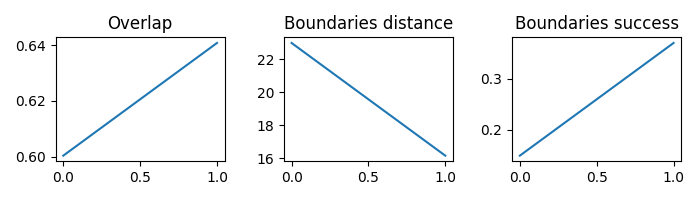

In [31]:
metrics = ['Overlap', 'Boundaries distance', 'Boundaries success']
fig,ax = plt.subplots(figsize=(7,2), ncols=len(metrics))
for e,key in enumerate(metrics):
    ax[e].plot(segments_scores[key])
    ax[e].set_title(key)
plt.tight_layout();

## Confusion matrices

The matrices show progress of:
1. Cluster separation
2. Relationship between GT clusters and the predicted labels

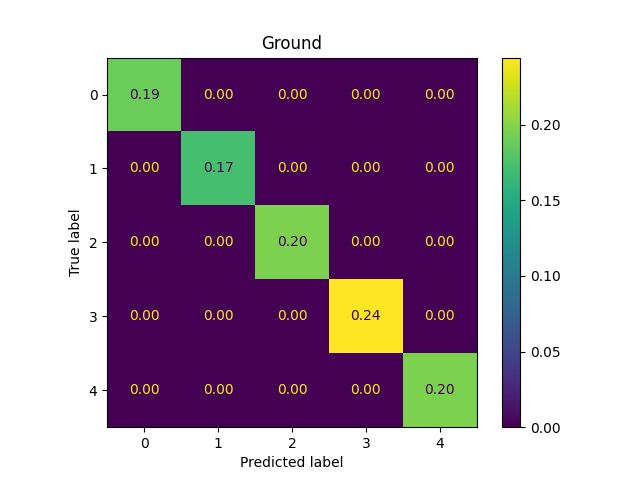

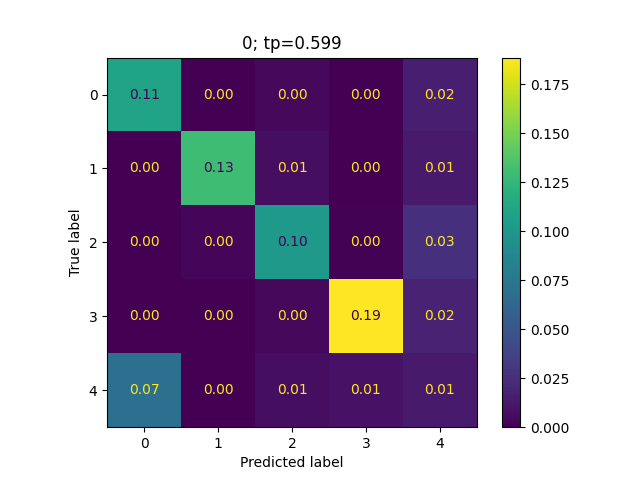

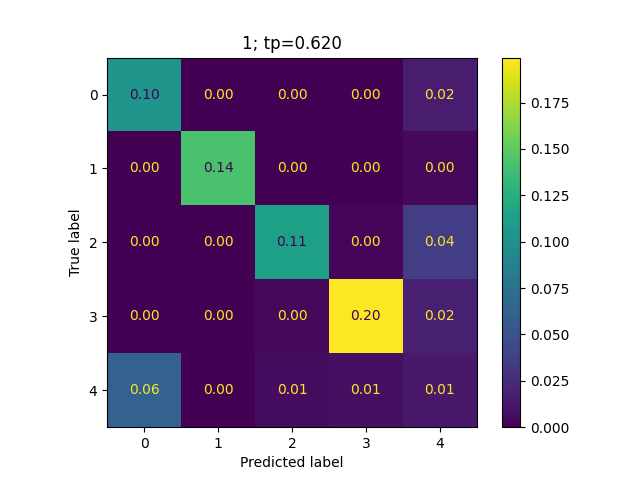

In [32]:
c_mat = confusion_matrix(tacom_history[0]['ground_labels'], tacom_history[0]['ground_labels'])/len(tacom_history[0]['ground_labels'])
disp = ConfusionMatrixDisplay(confusion_matrix=c_mat)
disp.plot(values_format='.2f')
plt.title('Ground')

for idx in np.arange(n_executed):
    temp_labels = overlap_new_labels[idx]
    c_mat = confusion_matrix(overlap_labels[idx][:,0], temp_labels)/len(tacom_history[0]['ground_labels'])
    if c_mat.shape != (n_clusters, n_clusters):
        missing = [i for i in np.arange(n_clusters) if i not in np.unique(overlap_labels[idx][:,0])]
        c_mat = np.insert(c_mat, missing, np.zeros(n_clusters), axis=0)

    tp = sum([np.max(row) for row in c_mat])

    disp = ConfusionMatrixDisplay(confusion_matrix=c_mat)
    disp.plot(values_format='.2f')
    plt.title(f'{idx}; tp={tp:.3f}')

## Direct segmentation comparison

In [33]:
colors = u.gen_colors(n_clusters)

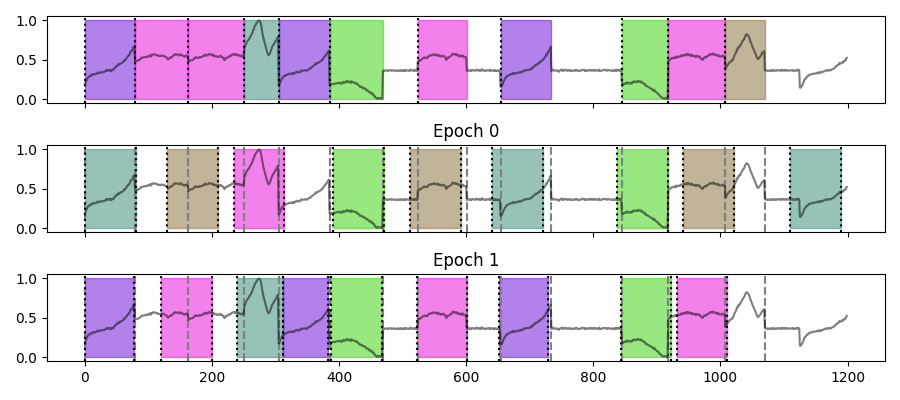

In [34]:
n_show = [0] + [1]

fig, ax = plt.subplots(figsize=(9,4), nrows=1+len(n_show), sharex=True)

fro, up_to = 0,1_200

for i,b in enumerate(tacom_history[0]['ground_boundaries']):
    if b[0] < fro: continue
    if b[1] >= up_to: break
    color = colors[tacom_history[0]['ground_labels'][i]]
    ax[0].fill_between(b, 1, color=color, alpha=0.5)
    ax[0].axvline(b[0], linestyle='dotted', color='black')
    for a in ax[1:]:
        a.axvline(b[0], linestyle='--', color='gray')
        a.axvline(b[1], linestyle='--', color='gray')
ax[0].plot(np.arange(fro, up_to), signal[fro:up_to,-1], color='black', alpha=0.5)

for e,idx in enumerate(n_show):
    if idx == 0:
        temp_labels = tacom_history[idx]['labels']
    else:
        temp_labels = overlap_new_labels[idx]
    for i,b in enumerate(tacom_history[idx]['boundaries']):
        if b[0] < fro: continue
        if b[1] >= up_to: break
        color = colors[temp_labels[i]]
        ax[1+e].fill_between(b, 1, color=color, alpha=0.5)
        ax[1+e].axvline(b[0], linestyle='dotted', color='black')
        ax[1+e].axvline(b[1], linestyle='dotted', color='black')
    ax[1+e].set_title(f'Epoch {idx}')
    ax[1+e].plot(np.arange(fro, up_to), signal[fro:up_to,-1], color='black', alpha=0.5)

plt.tight_layout();